# Model Evaluation, Cross-Validation, and Hyperparameter Tuning 

This file explores the initial performance of several machine learning models and conducts additional tests to improve model predictions. 

In [1]:
import warnings # ignore those warnings!

# general use packages
import matplotlib.pyplot as plt # visualization
import seaborn as sns # more viz
import numpy as np # basic munging
import pandas as pd # data management
import datetime as dt # ensure out date column is indeed a data column


# model packages
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler


# model assessment
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from yellowbrick.model_selection import CVScores


warnings.filterwarnings('ignore')

# %run Boston_311_Master_Merger_V2.ipynb

master = pd.read_csv("~/Documents/Georgetown SCS/capstone/boston-311/01 data/master.csv")

## Encoding

We're going to try two different encoding approaches:
1. One-hot encoding for our main string features of interest (source of 311 call and reason for 311 call) to widen our data frame and turn each string into its own 0/1 column
2. Ordinal encoding of string variables, which will keep our feature space the same, but ensure we are only dealing with numeric data

In [2]:
master.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492757 entries, 0 to 492756
Data columns (total 104 columns):
 #    Column                                              Dtype  
---   ------                                              -----  
 0    Unnamed: 0                                          int64  
 1    case_enquiry_id                                     int64  
 2    open_dt                                             object 
 3    target_dt                                           object 
 4    closed_dt                                           object 
 5    ontime                                              object 
 6    case_status                                         object 
 7    closure_reason                                      object 
 8    case_title                                          object 
 9    subject                                             object 
 10   reason                                              object 
 11   type                    

In [3]:
master.isna().sum()

Unnamed: 0             0
case_enquiry_id        0
open_dt                0
target_dt          72801
closed_dt          32715
                   ...  
Shape_STAr            51
Shape_STLe            51
ucr_one               51
ucr_two               51
total_ucr             51
Length: 104, dtype: int64

In [4]:
# let's split out our date columns

# first ensure our date column is indeed a date column
master['date'] = pd.to_datetime(master['date'])

# Breakout day, month, and year from the date field
master['day'] = master['date'].dt.day
master['month'] = master['date'].dt.month
master['year'] = master['date'].dt.year

# let's also ensure we only have numeric values

master['Total_P1'] = pd.to_numeric(master.Total_P1, errors='coerce')

master['GEOID20'] = pd.to_numeric(master.GEOID20, errors='coerce')


## Select the fields that will potentially be used for further feature selection and later modeling

In [5]:
# Define the fields we will use for ML
cols = ['case_enquiry_id','date','ontime','case_status','subject','reason'
        ,'PRCP'
        ,'Total_P1','GEOID20','ucr_one','ucr_two','total_ucr']
master = master[cols]

In [6]:
## Encoding

In [7]:
# One-hot encode categorical features
master_one_hot= pd.get_dummies(data=master, columns=['reason', 'subject', 'ontime'])

master_one_hot['closed'] = master_one_hot['case_status'].apply(lambda x: 1 if x=='Closed' else 0)

master_one_hot = master_one_hot.drop('case_status', axis=1)

master_one_hot.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492757 entries, 0 to 492756
Data columns (total 75 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   case_enquiry_id                            492757 non-null  int64         
 1   date                                       492757 non-null  datetime64[ns]
 2   PRCP                                       492757 non-null  float64       
 3   Total_P1                                   492706 non-null  float64       
 4   GEOID20                                    492706 non-null  float64       
 5   ucr_one                                    492706 non-null  float64       
 6   ucr_two                                    492706 non-null  float64       
 7   total_ucr                                  492706 non-null  float64       
 8   reason_Abandoned Bicycle                   492757 non-null  uint8         
 9   reas

In [8]:
# create simple numeric columns

# there is definitely an easier way to do this, but it didn't work when I combined these into a function
master_numeric = master
master_numeric['reason'] = pd.factorize(master_numeric['reason'])[0]
master_numeric['subject'] = pd.factorize(master_numeric['subject'])[0]
master_numeric['ontime'] = pd.factorize(master_numeric['ontime'])[0]



In [9]:
master_numeric.shape

(492757, 12)

In [10]:
master_numeric = master_numeric.dropna(subset = ['GEOID20'])

master_numeric.shape

(492706, 12)

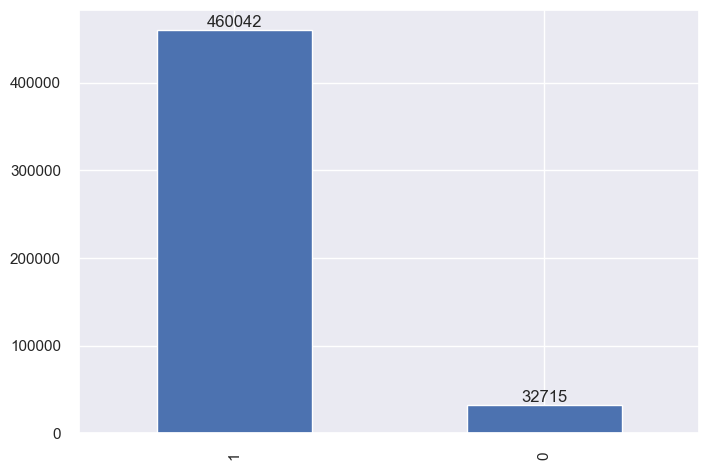

In [11]:
# we clearly have class imbalance
%matplotlib inline

sns.set_theme(style="darkgrid")

status_count_fig = master_one_hot['closed'].value_counts().plot(kind='bar')
status_count_fig.bar_label(status_count_fig.containers[0], fmt='%d' );



In [12]:
# let's rebalance with undersampling

closed=master_one_hot[master_one_hot.closed==1]
open=master_one_hot[master_one_hot.closed==0]

# upsample minority
open_upsampled = resample(open
                            , replace=True # sample with replacement 
                            , n_samples=len(closed) # match number in majority class
                          , random_state=12022022) # set seed

# combine majority and upsampled minority
upsampled = pd.concat([closed, open_upsampled])

# check new class counts
upsampled.closed.value_counts()

1    460042
0    460042
Name: closed, dtype: int64

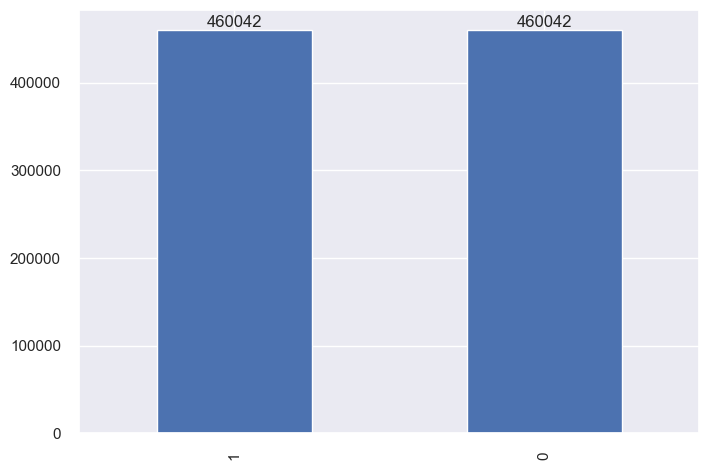

In [13]:
# now let's check our balance
status_count_fig = upsampled['closed'].value_counts().plot(kind='bar')
status_count_fig.bar_label(status_count_fig.containers[0], fmt='%d' );



In [14]:
# Prepare data for modeling
upsampled = upsampled.dropna(subset = ['GEOID20'])


X = upsampled.drop('closed', axis=1)
X = X.drop('case_enquiry_id', axis = 1)
#X['date']=X['date'].map(dt.datetime)

# create year columns
X['year'] = X['date'].dt.year

X['month'] = X['date'].dt.month

y = upsampled['closed']



In [15]:
# drop this since we have split up the date into years and months
del X['date']


# let's remove the ontime stats since these are very unbalanced and highly correlated with closure
del X['ontime_ONTIME']
del X['ontime_OVERDUE']

#### test, train split


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [17]:
# feature scaling
scale_vars = StandardScaler()

X_train = scale_vars.fit_transform(X_train)  
X_test = scale_vars.transform(X_test)

In [18]:

data_dmatrix = xgb.DMatrix(data=X,label=y)

xgb_reg = XGBClassifier() 
# fit model
xgb_reg.fit(X_train, y_train)
# make predictions
preds = xgb_reg.predict(X_test)


In [19]:
# check the performance

rmse = np.sqrt(mean_squared_error(y_test, preds))

print("RMSE: %f" % (rmse))

# mmmm, just ok

RMSE: 0.417979


In [20]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[10:11:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:11:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:11:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [21]:
# let's take a look
cv_results.head()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.490186,0.000037,0.490187,0.000017
1,0.480513,0.003846,0.480535,0.003795
2,0.471898,0.004044,0.471892,0.003995
3,0.465663,0.007374,0.465652,0.007339
4,0.458429,0.004534,0.458419,0.004516


In [22]:
print((cv_results["test-rmse-mean"]).tail(1))
# cross validation reduced our RMSE

49    0.373699
Name: test-rmse-mean, dtype: float64


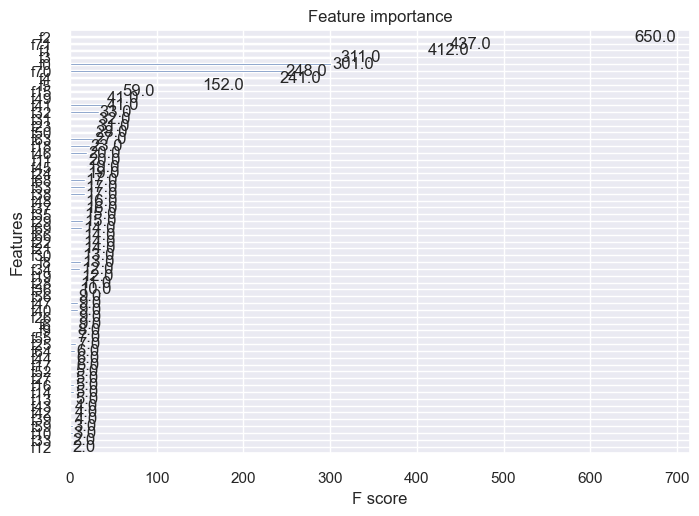

In [23]:
# let's look at feature importance

xgb.plot_importance(xgb_reg)
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

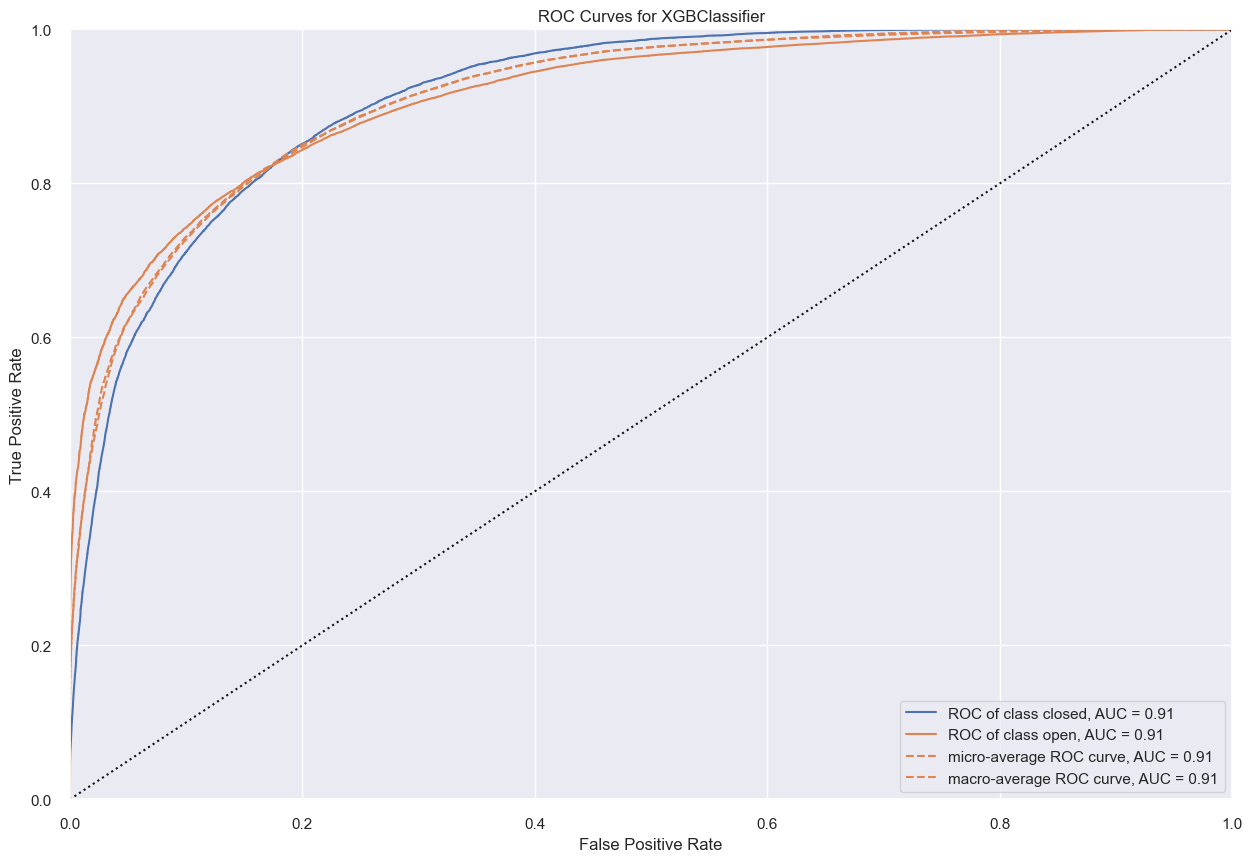

In [24]:
from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError
classes = ['closed', 'open']
visualizer = ROCAUC(xgb_reg, classes=classes)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  

r = visualizer.poof()

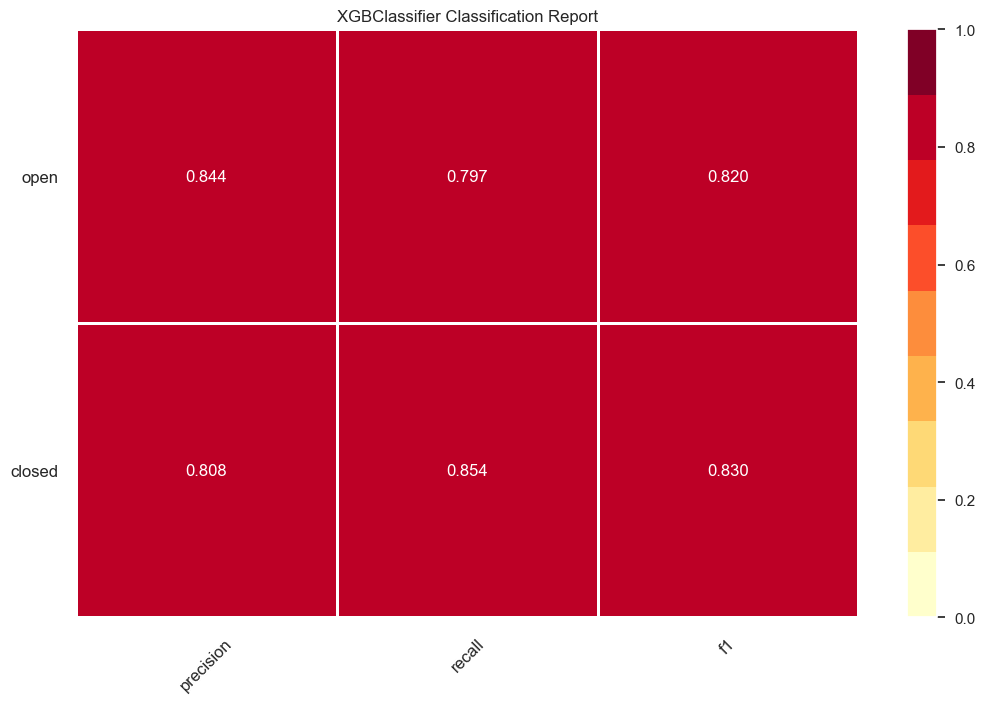

In [25]:
report = ClassificationReport(xgb_reg, size=(1080, 720), classes=classes)

report.score(X_test, y_test)
c = report.poof()

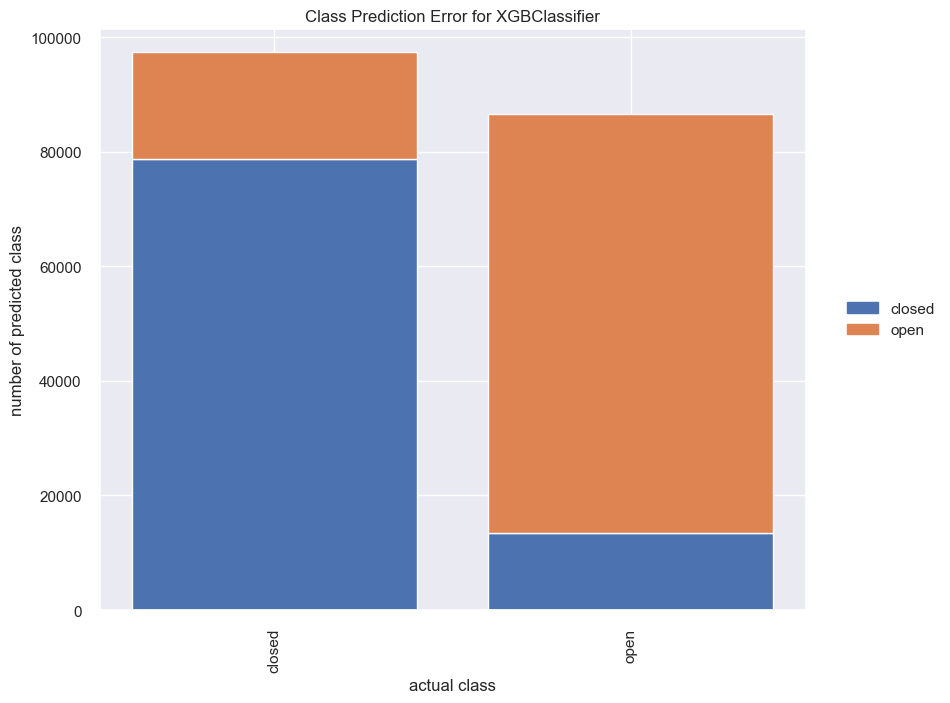

In [26]:
error = ClassPredictionError(xgb_reg, size=(1080, 720), classes=classes)

error.score(X_test, y_test)
e = error.poof()

In [27]:
# ok, so xgboost performs well, let's try a few other models

def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))



models = [
    LogisticRegression()
    , ExtraTreesClassifier()
    , RandomForestClassifier()
]

for model in models:
    score_model(X, y, model)
    

LogisticRegression: 0.7999843088906946
ExtraTreesClassifier: 0.9239829163959585
RandomForestClassifier: 0.9240145595991384


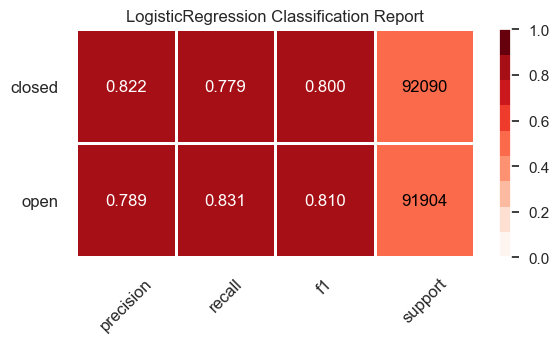

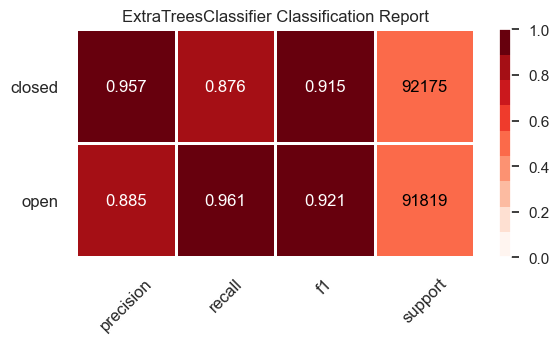

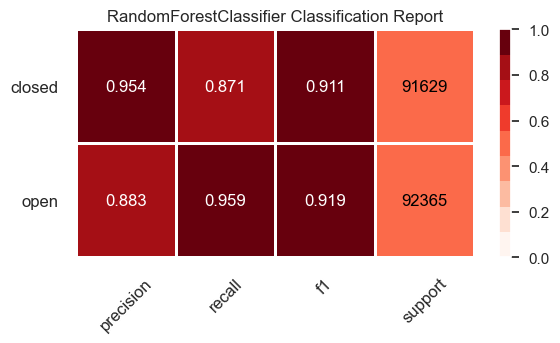

In [28]:
def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, 
        classes=['open', 'closed'], 
        cmap="Reds", 
        support=True,
        size=(600, 360)
    )
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20)
    
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    visualizer.show()  

for model in models:
    visualize_model(X, y, model)


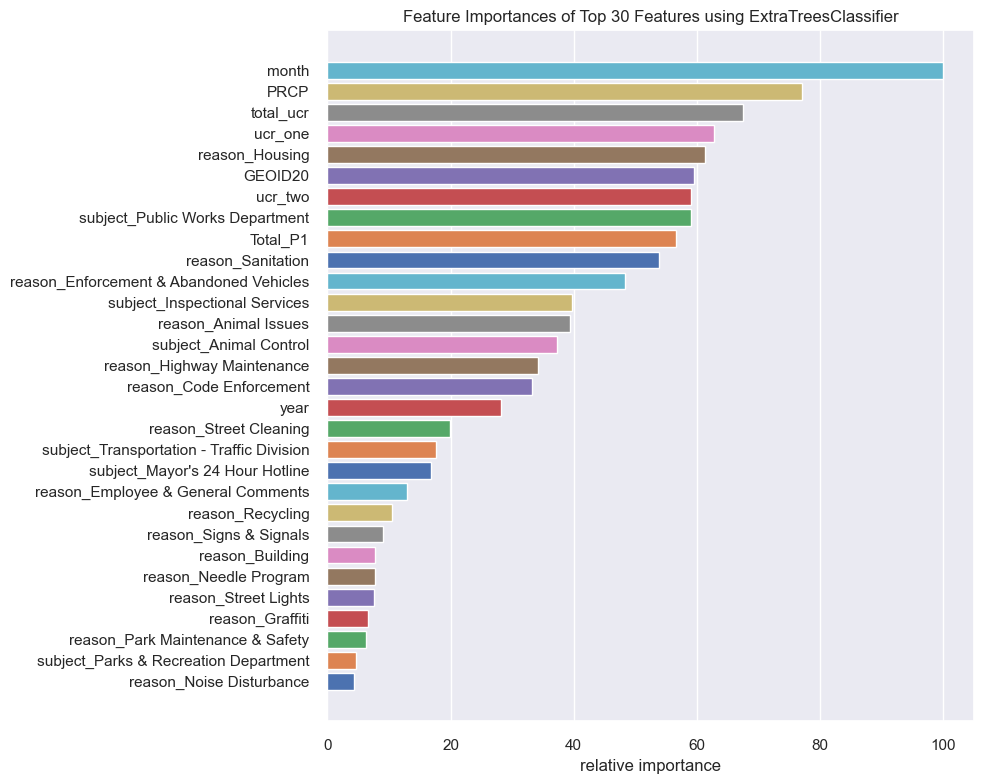

<AxesSubplot:title={'center':'Feature Importances of Top 30 Features using ExtraTreesClassifier'}, xlabel='relative importance'>

In [46]:
from sklearn.ensemble import ExtraTreesClassifier
from yellowbrick.features import FeatureImportances

model = ExtraTreesClassifier(n_estimators=10)
viz = FeatureImportances(model,  size=(1000, 800), topn=30)

viz.fit(X, y)
viz.show()

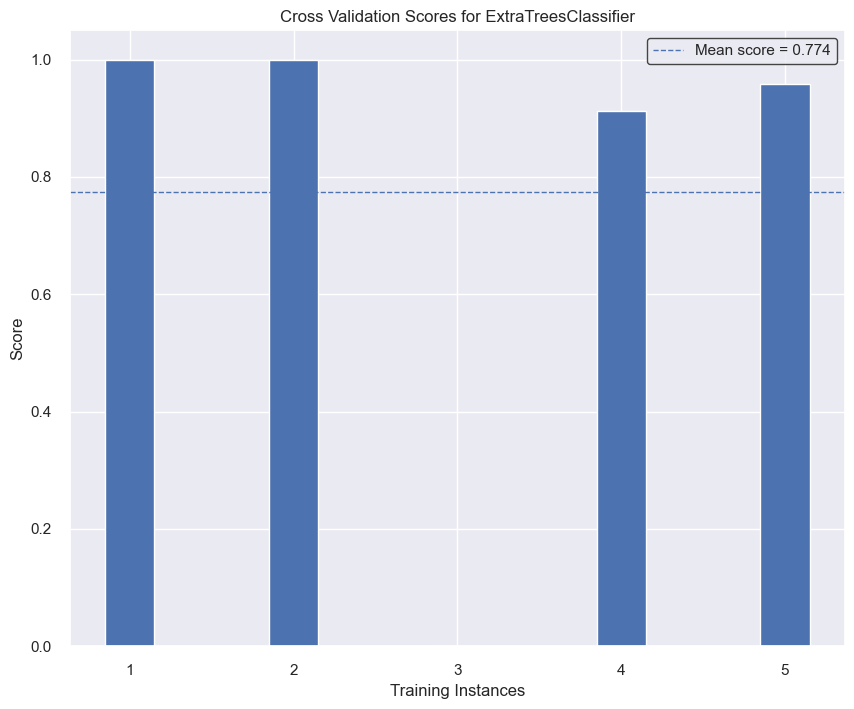

<AxesSubplot:title={'center':'Cross Validation Scores for ExtraTreesClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [74]:
# hyperparameter tuning

cv = TimeSeriesSplit()

more_trees = ExtraTreesClassifier()
cvtrees = CVScores(more_trees, cv=cv, scoring='f1_weighted', size=(1000, 800))

cvtrees.fit(X, y)
cvtrees.show()

In [92]:
# grid search to improve tuning
from sklearn.model_selection import GridSearchCV
          
gsc = GridSearchCV(
    estimator=more_trees,
    param_grid={
        'min_samples_leaf': range(2, 10),
        'min_samples_split': range(5,20,5),
    },
    scoring='f1_weighted',
    cv=5
)

grid_result = gsc.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

model = ExtraTreesClassifier(**grid_result.best_params_)

model.fit(X_train, y_train)

Best: 0.889939 using {'min_samples_leaf': 2, 'min_samples_split': 5}


ExtraTreesClassifier(min_samples_leaf=2, min_samples_split=5)

In [93]:
# test a more parsimonious model
X_final = X[['month', 'PRCP', 'total_ucr', 'ucr_one', 'reason_Housing', 'GEOID20', 'ucr_two', 'subject_Public Works Department', 'Total_P1', 'reason_Sanitation', 'reason_Enforcement & Abandoned Vehicles', 'subject_Inspectional Services', 'reason_Animal Issues', 'subject_Animal Control', 'reason_Highway Maintenance', 'reason_Code Enforcement', 'year', 'reason_Street Cleaning','subject_Transportation - Traffic Division'  ]]
y_final = y

In [96]:

X_train, X_test, y_train, y_test = tts(X_final, y_final, test_size=0.20)

more_trees = ExtraTreesClassifier()
# the defaults actually perform best!

more_trees.fit(X_test, y_test)
y_pred_final = more_trees.predict(X_final)
     

more_trees.score(X_final, y_final)

0.8889582148963715

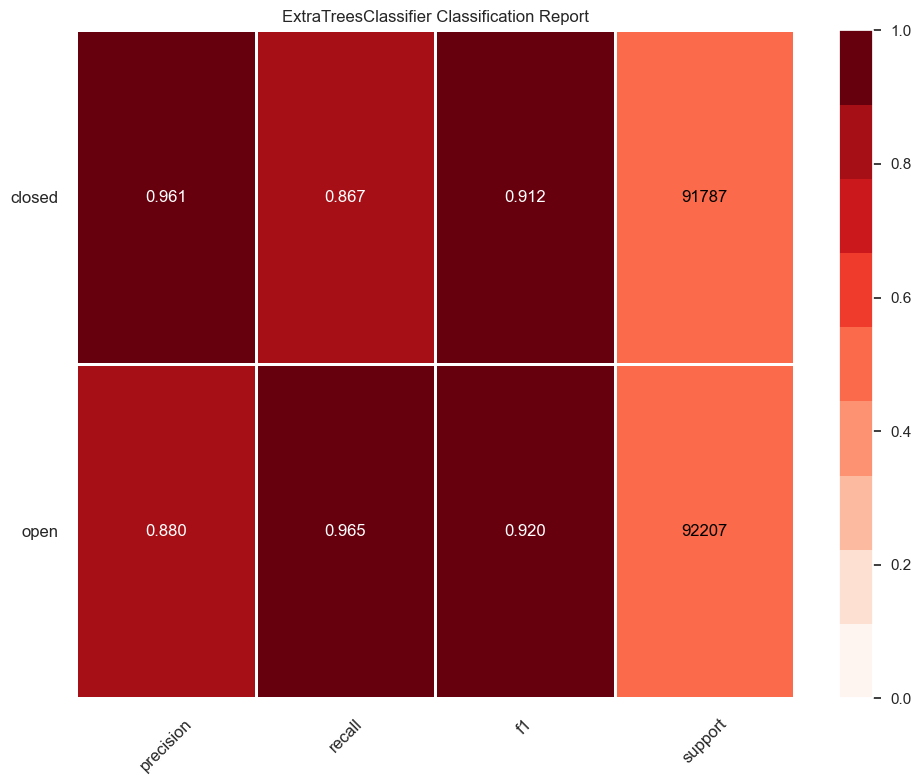

<AxesSubplot:title={'center':'ExtraTreesClassifier Classification Report'}>

In [97]:
visualizer = ClassificationReport(
        more_trees, 
        classes=['open', 'closed'], 
        cmap="Reds", 
        support=True,
        size=(1000, 800)
    )
        
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)
visualizer.show() 

In [47]:
# unfortunately if we group by census tract there aren't enough open calls in some tracts to estimate a model, so we'll see
# which tracts have a very low number of calls and then subset our data based on the call count
df =  pd.concat([X, y], axis=1)
closed_calls = df.groupby("GEOID20").agg({'closed': ['sum']}).reset_index()   
closed_calls.columns = ['GEOID20', 'sum']

closed_calls.sort_values('sum', ascending=True)

,GEOID20,sum
569,2.502598e+11,12
566,2.502598e+11,16
575,2.502598e+11,25
27,2.502500e+11,28
529,2.502513e+11,36
...,...,...
253,2.502507e+11,2483
98,2.502501e+11,2557
261,2.502508e+11,2589
230,2.502507e+11,2715


In [33]:
call_counts = df.groupby(['GEOID20'])['closed'].agg('sum').reset_index()   

In [34]:
call_counts2 = call_counts[call_counts["closed"] > 100]

In [35]:
df2 = df.loc[df['GEOID20'].isin(call_counts2['GEOID20'])]


In [36]:
df2.head()

,PRCP,Total_P1,GEOID20,ucr_one,ucr_two,total_ucr,reason_Abandoned Bicycle,reason_Administrative,reason_Administrative & General Requests,reason_Air Pollution Control,...,subject_Inspectional Services,subject_Mayor's 24 Hour Hotline,subject_Neighborhood Services,subject_Parks & Recreation Department,subject_Property Management,subject_Public Works Department,subject_Transportation - Traffic Division,year,month,closed
0,0.4,2120.0,2.502511e+11,101.0,436.0,537.0,0,0,0,0,...,0,0,0,0,0,1,0,2015,6,1
3,0.4,610.0,2.502507e+11,617.0,1644.0,2261.0,0,0,0,0,...,0,0,0,0,0,1,0,2015,6,1
5,0.4,719.0,2.502512e+11,53.0,58.0,111.0,0,0,0,0,...,0,0,0,0,0,0,1,2015,6,1
6,0.4,2282.0,2.502500e+11,31.0,182.0,213.0,0,0,0,0,...,0,0,0,0,0,1,0,2015,6,1
7,0.4,1025.0,2.502503e+11,55.0,124.0,179.0,0,0,0,0,...,0,0,0,0,1,0,0,2015,6,1


In [55]:

def GroupRegress(data, yvar, xvars):
    y = data[yvar]
    X = data[xvars]
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20)
    result = ExtraTreesClassifier().fit(X,y)
    preds = result.predict(X_test)
    return preds

outcomes = df2.groupby('GEOID20').apply(GroupRegress, 'closed', ['total_ucr', 'ucr_one', 'ucr_two', 'month', 'year'
                                                                         ,'reason_Abandoned Bicycle',
                                                                        'reason_Administrative',
                                                                        'reason_Administrative & General Requests',
                                                                        'reason_Air Pollution Control',
                                                                        'reason_Alert Boston',
                                                                        'reason_Animal Issues',
                                                                        'reason_Billing',
                                                                        'reason_Boston Bikes',
                                                                        'reason_Bridge Maintenance',
                                                                        'reason_Building',
                                                                        'reason_Catchbasin',
                                                                        'reason_Cemetery',
                                                                        'reason_Code Enforcement',
                                                                        'reason_Consumer Affairs Issues',
                                                                        'reason_Current Events',
                                                                        'reason_Disability',
                                                                        'reason_Employee & General Comments',
                                                                        'reason_Enforcement & Abandoned Vehicles',
                                                                        'reason_Environmental Services',
                                                                        'reason_Fire Department',
                                                                        'reason_Fire Hydrant',
                                                                        'reason_General Request',
                                                                        'reason_Generic Noise Disturbance',
                                                                        'reason_Graffiti',
                                                                        'reason_Health',
                                                                        'reason_Highway Maintenance',
                                                                        'reason_Housing',
                                                                        'reason_MBTA',
                                                                        'reason_Massport',
                                                                        'reason_Needle Program',
                                                                        'reason_Neighborhood Services Issues',
                                                                        'reason_Noise Disturbance',
                                                                        'reason_Notification',
                                                                        'reason_Office of The Parking Clerk',
                                                                        'reason_Operations',
                                                                        'reason_Park Maintenance & Safety',
                                                                        'reason_Parking Complaints',
                                                                        'reason_Pothole',
                                                                        'reason_Programs',
                                                                        'reason_Recycling',
                                                                        'reason_Sanitation',
                                                                        'reason_Sidewalk Cover / Manhole',
                                                                        'reason_Signs & Signals',
                                                                        'reason_Street Cleaning',
                                                                        'reason_Street Lights',
                                                                        'reason_Test Cases',
                                                                        'reason_Traffic Management & Engineering',
                                                                        'reason_Trees',
                                                                        'reason_Valet',
                                                                        'reason_Water Issues',
                                                                        'reason_Weights and Measures',
                                                                        'subject_Animal Control',
                                                                        'subject_Boston Police Department',
                                                                        'subject_Boston Water & Sewer Commission',
                                                                        'subject_CRM Application',
                                                                        'subject_Consumer Affairs & Licensing',
                                                                        'subject_Disability Department',
                                                                        'subject_Inspectional Services',
                                                                        "subject_Mayor's 24 Hour Hotline",
                                                                        'subject_Neighborhood Services',
                                                                        'subject_Parks & Recreation Department',
                                                                        'subject_Property Management',
                                                                        'subject_Public Works Department',
                                                                        'subject_Transportation - Traffic Division'
                                                                        ])

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [67]:
X_test['predictions'] = preds

In [69]:
output_df = X_test.groupby(['GEOID20'])['predictions'].mean().reset_index()


In [70]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GEOID20      579 non-null    float64
 1   predictions  579 non-null    float64
dtypes: float64(2)
memory usage: 9.2 KB


In [71]:
output_df.to_csv("~/Documents/Georgetown SCS/capstone/boston-311/03 output/predictions.csv")